<a href="https://colab.research.google.com/github/rahiakela/deep-learning-research-and-practice/blob/main/deep-learning-with-pytorch-step-by-step/Part-III-NLP/07_word_embeddings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Word Embeddings

We’ll start our NLP journey by following the steps of Alice and Dorothy, from
[Alice’s Adventures in Wonderland](https://ota.bodleian.ox.ac.uk/repository/xmlui/handle/20.500.12024/1476) by Lewis Carroll and [The Wonderful Wizard of Oz](https://ota.bodleian.ox.ac.uk/repository/xmlui/handle/20.500.12024/1740) by L. Frank Baum.

![](https://github.com/rahiakela/deep-learning-research-and-practice/blob/main/deep-learning-with-pytorch-step-by-step/Part-III-NLP/images/alice_dorothy.png?raw=1)

*Left: "Alice and the Baby Pig" illustration by John Tenniel's, from "Alice's Adventure's in Wonderland" (1865).*

*Right: "Dorothy meets the Cowardly Lion" illustration by W.W. Denslow, from "The Wonderful Wizard of Oz" (1900)*

##Setup

In [1]:
%%capture

# # UPDATED
# ###########################################################
!pip install gensim==4.3.1
# # The library has been archived and won't be used anymore
# # # !pip install allennlp==0.9.0
#!pip install flair==0.12.2
#!pip install torchvision==0.15.1
# # # HuggingFace
!pip install transformers==4.32.0
!pip install datasets==2.14.4
# ###########################################################
!pip -q install spacy
!python -m spacy download en_core_web_sm

In [2]:
try:
    import google.colab
    import requests
    url = 'https://raw.githubusercontent.com/dvgodoy/PyTorchStepByStep/master/config.py'
    r = requests.get(url, allow_redirects=True)
    open('config.py', 'wb').write(r.content)
except ModuleNotFoundError:
    pass

from config import *
config_chapter11()
# This is needed to render the plots in this chapter
from plots.chapter11 import *

Finished!


In [3]:
import os
import json
import errno
import requests
import numpy as np
from copy import deepcopy
from operator import itemgetter

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, Dataset

from data_generation.nlp import ALICE_URL, WIZARD_URL, download_text
from stepbystep.v4 import StepByStep
# These are the classes we built in Chapter 10
from seq2seq import *

import spacy
import nltk
from nltk.tokenize import sent_tokenize

In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
import gensim
from gensim import corpora, downloader
from gensim.parsing.preprocessing import *
from gensim.utils import simple_preprocess
from gensim.models import Word2Vec

In [ ]:
from datasets import load_dataset, Split
from transformers import (
    DataCollatorForLanguageModeling,
    BertModel, BertTokenizer, BertForSequenceClassification,
    DistilBertModel, DistilBertTokenizer,
    DistilBertForSequenceClassification,
    AutoModelForSequenceClassification,
    AutoModel, AutoTokenizer, AutoModelForCausalLM,
    Trainer, TrainingArguments, pipeline, TextClassificationPipeline
)
from transformers.pipelines import SUPPORTED_TASKS

##Downloading Books

In [ ]:
!rm -rf data

In [ ]:
# let's download data
HOME_DIR = "data"
download_text(ALICE_URL, HOME_DIR)
download_text(WIZARD_URL, HOME_DIR)

In [ ]:
# let's see the downloaded data
#!cat data/alice28-1476.txt

In [ ]:
#!cat data/wizoz10-1740.txt

We need to remove these additions to the original texts:

In [ ]:
alice_file = os.path.join(HOME_DIR, "alice28-1476.txt")
with open(alice_file, "r") as f:
  # The actual texts of the books are contained between lines 105 and 3703
  alice_text = "".join(f.readlines()[104:3704])

wizard_file = os.path.join(HOME_DIR, "wizoz10-1740.txt")
with open(wizard_file, "r") as f:
  # The actual texts of the books are contained between lines 309 and 5099
  wizard_text = "".join(f.readlines()[310:5100])

In [ ]:
print(alice_text[:500])
print("\n", "#"*70, "\n")
print(wizard_text[:500])

                ALICE'S ADVENTURES IN WONDERLAND

                          Lewis Carroll

               THE MILLENNIUM FULCRUM EDITION 2.8




                            CHAPTER I

                      Down the Rabbit-Hole


  Alice was beginning to get very tired of sitting by her sister
on the bank, and of having nothing to do:  once or twice she had
peeped into the book her sister was reading, but it had no
pictures or conversations in it, `and what is the use of a book,'
thought Alice `w

 ###################################################################### 

                    THE WONDERFUL WIZARD OF OZ


                          1.  The Cyclone


    Dorothy lived in the midst of the great Kansas prairies, with
Uncle Henry, who was a farmer, and Aunt Em, who was the farmer's
wife.  Their house was small, for the lumber to build it had to be
carried by wagon many miles.  There were four walls, a floor and a
roof, which made one room; and this room contained a rusty looking

We can partially automate the removal of the extra lines by setting the real start and end lines of each text in a configuration file.

In [ ]:
text_cfg = """fname,start,end
alice28-1476.txt,104,3704
wizoz10-1740.txt,310,5100"""
bytes_written = open(os.path.join(HOME_DIR, 'lines.cfg'), 'w').write(text_cfg)

##Sentence Tokenization

A token is a piece of a text, and to tokenize a text means to split
it into pieces; that is, into a list of tokens.

The most common kind of piece is a word.

So, tokenizing a text usually means to
split it into words using the white space as a separator.

In [ ]:
sentence = "I'm following the white rabbit"
tokens = sentence.split(" ")
tokens

["I'm", 'following', 'the', 'white', 'rabbit']

Let's do sentence tokenization, which means to split a text into its sentences.

In [ ]:
corpus_alice = sent_tokenize(alice_text)
corpus_wizard = sent_tokenize(wizard_text)

len(corpus_alice), (len(corpus_wizard))

(1612, 2240)

Let’s check one sentence from the first corpus of text.

In [ ]:
corpus_alice[2]

'There was nothing so VERY remarkable in that; nor did Alice\nthink it so VERY much out of the way to hear the Rabbit say to\nitself, `Oh dear!'

Let’s check one sentence from the second corpus of text.

In [ ]:
corpus_wizard[30]

'"There\'s a cyclone coming, Em," he called to his wife.'

Our dataset is going to be a collection of CSV files, one file for each book, with each
CSV file containing one sentence per line.

Therefore, we need to:

* clean the line breaks to make sure each sentence is on one line only;
* define an appropriate quote char to "wrap" the sentence such that the original commas and semicolons in the original text do not get misinterpreted as separation chars of the CSV file; and
* add a second column to the CSV file to
identify the original source of the sentence since we’ll be concatenating, and
shuffling the sentences before training a model on our corpora.

The sentence above should end up looking like this:
```log
\"There's a cyclone coming, Em," he called to his wife.\,wizoz10-1740.txt
```

The function below does the grunt work of cleaning, splitting, and saving the
sentences to a CSV file for us:

In [ ]:
def sentence_tokenize(source, quote_char="\\", sep_char=",", include_header=True, include_source=True, extensions=("txt"), **kwargs):
  # If source is a folder, goes through all files inside it that match the desired extensions ('txt' by default)
  if os.path.isdir(source):
    filenames = [f for f in os.listdir(source) if os.path.isfile(os.path.join(source, f)) and os.path.splitext(f)[1][1:] in extensions]
  elif isinstance(source, str):
    filenames = [source]

  # If there is a configuration file, builds a dictionary with the corresponding start and end lines of each text file
  config_file = os.path.join(source, "lines.cfg")
  config = {}
  if os.path.exists(config_file):
    with open(config_file, "r") as f:
      rows = f.readlines()
    for r in rows[1:]:
      fname, start, end = r.strip().split(",")
      config.update({fname: (int(start), int(end))})

  new_fnames = []
  # For each file of text
  for fname in filenames:
    # If there's a start and end line for that file, use it
    try:
        start, end = config[fname]
    except KeyError:
        start = None
        end = None

    # Opens the file, slices the configures lines (if any)
    # cleans line breaks and uses the sentence tokenizer
    with open(os.path.join(source, fname), 'r') as f:
        contents = (''.join(f.readlines()[slice(start, end, None)]).replace('\n', ' ').replace('\r', ''))
    corpus = sent_tokenize(contents, **kwargs)

    # Builds a CSV file containing tokenized sentences
    base = os.path.splitext(fname)[0]
    new_fname = f'{base}.sent.csv'
    new_fname = os.path.join(source, new_fname)
    with open(new_fname, 'w') as f:
        # Header of the file
        if include_header:
            if include_source:
                f.write('sentence,source\n')
            else:
                f.write('sentence\n')
        # Writes one line for each sentence
        for sentence in corpus:
            if include_source:
                f.write(f'{quote_char}{sentence}{quote_char}{sep_char}{fname}\n')
            else:
                f.write(f'{quote_char}{sentence}{quote_char}\n')
    new_fnames.append(new_fname)

  # Returns list of the newly generated CSV files
  return sorted(new_fnames)

In [ ]:
new_fnames = sentence_tokenize(HOME_DIR)
new_fnames

['data/alice28-1476.sent.csv', 'data/wizoz10-1740.sent.csv']

##Spacy sentence tokenization

In [ ]:
nlp = spacy.blank("en")
nlp.add_pipe("sentencizer")

sentences = []
for doc in nlp.pipe(corpus_alice):
  sentences.extend(sent.text for sent in doc.sents)

len(sentences), sentences[2]

(1615,
 'There was nothing so VERY remarkable in that; nor did Alice\nthink it so VERY much out of the way to hear the Rabbit say to\nitself, `Oh dear!')

##HuggingFace’s Dataset

In [ ]:
# let's load from local files using HuggingFace
dataset = load_dataset(path="csv", data_files=new_fnames, quotechar="\\", split=Split.TRAIN)

In [ ]:
# let's see attributes, like features, num_columns, and shape
dataset.features, dataset.num_columns, dataset.shape

({'sentence': Value(dtype='string', id=None),
  'source': Value(dtype='string', id=None)},
 2,
 (3852, 2))

In [ ]:
dataset[2]

{'sentence': 'There was nothing so VERY remarkable in that; nor did Alice think it so VERY much out of the way to hear the Rabbit say to itself, `Oh dear!',
 'source': 'alice28-1476.txt'}

In [ ]:
dataset["sentence"][:3]

["                ALICE'S ADVENTURES IN WONDERLAND                            Lewis Carroll                 THE MILLENNIUM FULCRUM EDITION 2.8                                 CHAPTER I                        Down the Rabbit-Hole     Alice was beginning to get very tired of sitting by her sister on the bank, and of having nothing to do:  once or twice she had peeped into the book her sister was reading, but it had no pictures or conversations in it, `and what is the use of a book,' thought Alice `without pictures or conversation?'",
 'So she was considering in her own mind (as well as she could, for the hot day made her feel very sleepy and stupid), whether the pleasure of making a daisy-chain would be worth the trouble of getting up and picking the daisies, when suddenly a White Rabbit with pink eyes ran close by her.',
 'There was nothing so VERY remarkable in that; nor did Alice think it so VERY much out of the way to hear the Rabbit say to itself, `Oh dear!']

In [ ]:
dataset["source"][:3]

['alice28-1476.txt', 'alice28-1476.txt', 'alice28-1476.txt']

In [ ]:
# check the unique sources
dataset.unique("source")

['alice28-1476.txt', 'wizoz10-1740.txt']

In [ ]:
# let's create new columns
def is_alice_label(row):
  is_alice = int(row["source"] == "alice28-1476.txt")
  return {"label": is_alice}

In [ ]:
dataset = dataset.map(is_alice_label)

Map:   0%|          | 0/3852 [00:00<?, ? examples/s]

In [ ]:
dataset[2]

{'sentence': 'There was nothing so VERY remarkable in that; nor did Alice think it so VERY much out of the way to hear the Rabbit say to itself, `Oh dear!',
 'source': 'alice28-1476.txt',
 'label': 1}

In [ ]:
# Now, we can finally shuffle the dataset and split it into training and test sets
shuffled_dataset = dataset.shuffle(seed=42)
split_dataset = shuffled_dataset.train_test_split(test_size=0.2)
split_dataset

DatasetDict({
    train: Dataset({
        features: ['sentence', 'source', 'label'],
        num_rows: 3081
    })
    test: Dataset({
        features: ['sentence', 'source', 'label'],
        num_rows: 771
    })
})

In [ ]:
train_dataset = split_dataset["train"]
test_dataset = split_dataset["test"]

In [ ]:
train_dataset[0]

{'sentence': '"And back to Kansas?"', 'source': 'wizoz10-1740.txt', 'label': 0}

##Vocabulary

In [ ]:
sentences = train_dataset["sentence"]
tokens = [simple_preprocess(sent) for sent in sentences]

In [ ]:
# build a vocabulary
dictionary = corpora.Dictionary(tokens)
print(dictionary)

Dictionary<3677 unique tokens: ['and', 'back', 'kansas', 'to', 'as']...>


In [ ]:
vocab = list(dictionary.token2id.keys())
vocab[:5]

['and', 'back', 'kansas', 'to', 'as']

In [ ]:
# add special token to unknown word
special_tokens = {
    "[PAD]": 0,
    "[UNK]": 1
}

dictionary.patch_with_special_tokens(special_tokens)

In [ ]:
def get_rare_ids(dictionary, min_freq):
  rare_ids = [t[0] for t in dictionary.cfs.items() if t[1] < min_freq]
  return rare_ids

In [ ]:
def make_vocab(sentences, folder=None, special_tokens=None, vocab_size=None, min_freq=None):

  if folder is not None:
    if not os.path.exists(folder):
      os.mkdir(folder)

  # tokenizes the sentences and create a Dictionary
  tokens = [simple_preprocess(sent) for sent in sentences]
  dictionary = corpora.Dictionary(tokens)

  # keeps only the most frequent words (vocab size)
  if vocab_size is not None:
    dictionary.filter_extremes(keep_n=vocab_size)

  # removes rare words (in case the vocab size still includes words with low frequency)
  if min_freq is not None:
    rare_tokens = get_rare_ids(dictionary, min_freq)
    dictionary.filter_tokens(bad_ids=rare_tokens)

  # gets the whole list of tokens and frequencies
  items = dictionary.cfs.items()

  # sorts the tokens in descending order
  words = [dictionary[t[0]] for t in sorted(dictionary.cfs.items(), key=lambda t: -t[1])]

  # prepends special tokens, if any
  if special_tokens is not None:
    to_add = []
    for special_token in special_tokens:
      if special_token not in words:
        to_add.append(special_token)
    words = to_add + words

  with open(os.path.join(folder, "vocab.txt"), "w") as f:
    for word in words:
      f.write(f"{word}\n")

In [ ]:
make_vocab(
    train_dataset["sentence"],
    "our_vocab/",
    special_tokens=['[PAD]', '[UNK]', '[SEP]', '[CLS]', '[MASK]'],
    min_freq=2
)

## HugginFace's Tokenizer

So, before loading a pre-trained tokenizer, let’s create our own tokenizer using our
own vocabulary.

In [ ]:
tokenizer = BertTokenizer("our_vocab/vocab.txt")

Let’s apply our tokenizer to our dataset of sentences, padding them and
returning PyTorch tensors:

In [ ]:
tokenized_dataset = tokenizer(dataset["sentence"],
                              padding=True,
                              return_tensors="pt",
                              max_length=50,
                              truncation=True)
tokenized_dataset["input_ids"]

tensor([[   3,   26,    1,  ...,  103,  867,    2],
        [   3,   24,   10,  ..., 1304,    5,    2],
        [   3,   50,   12,  ...,    0,    0,    0],
        ...,
        [   3,    1,    6,  ...,    0,    0,    0],
        [   3,    6,  130,  ...,    0,    0,    0],
        [   3,    1,    1,  ...,    0,    0,    0]])

Can we feed the input_ids to BERT and watch the magic happen?

BERT is actually using vectors to represent the words. The
token IDs we’ll be sending it are simply the indices of an enormous lookup table.

That lookup table has a very nice name: **Word Embeddings**.

Each row of the lookup table corresponds to a different token, and each row is
represented by a vector. The size of the vectors is the dimensionality of the
embedding.

##Text representation

Before getting to the actual word embeddings, let’s start with the basics and text representations.

###One-Hot Encoding

The idea behind OHE is quite simple: Each unique token (word) is represented by a vector full of zeros except for one position, which corresponds to the token’s index.

Let’s see one-hot encoding representations for 5 words.

![](https://github.com/rahiakela/deep-learning-research-and-practice/blob/main/deep-learning-with-pytorch-step-by-step/Part-III-NLP/images/ohe1.png?raw=1)

But there are 3,704 unique tokens in our text
corpora (not counting the added special tokens), so the OHE actually looks like this.

![](https://github.com/rahiakela/deep-learning-research-and-practice/blob/main/deep-learning-with-pytorch-step-by-step/Part-III-NLP/images/ohe2.png?raw=1)

That’s quite a large and sparse vector, right?

Clearly, this isn’t very practical.

Nonetheless, the sparse vectors produced by the one-hot
encoding are the basis of a fairly basic NLP model: the bag-of-words (BoW).

###Bag-of-Words

The bag-of-words model is literally a bag of words: It simply sums up the
corresponding OHE vectors, completely disregarding any underlying structure or
relationships between the words.

In [ ]:
sentence = "the white rabbit is a rabbit"
bow_tokens = simple_preprocess(sentence)
bow_tokens

['the', 'white', 'rabbit', 'is', 'rabbit']

In [ ]:
bow = dictionary.doc2bow(bow_tokens)
bow

[(18, 1), (35, 1), (631, 2), (1077, 1)]

Representing words using
one-hot-encoded vectors also presents severe limitations: Not only do the vectors become more and more sparse (that is, have more zeros in them) as the vocabulary
grows, but also every word is orthogonal to all the other words.

If we use one-hot-encoded vectors to represent words, we’re
basically saying that no two words are similar to each other.

##Word Embeddings

Word2Vec has two model architectures: continuous bag-of-words (CBoW) and skip-gram (SG).

###Word2Vec

In [4]:
class CBOW(nn.Module):
  def __init__(self, vocab_size, embedding_size):
    super().__init__()

    self.embedding = nn.Embedding(vocab_size, embedding_size)
    self.linear = nn.Linear(embedding_size, vocab_size)

  def forward(self, X):
    embeddings = self.embedding(X)
    bow = embeddings.mean(dim=1)
    logits = self.linear(bow)
    return logits

If our vocabulary had only five words ("the,"
"small," "is," "barking," and "dog"), we could try to represent each word with an
embedding of three dimensions.

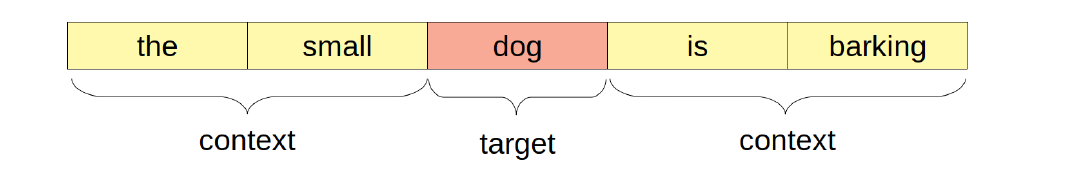

In [5]:
torch.manual_seed(42)

dummy_cbow = CBOW(vocab_size=5, embedding_size=3)
dummy_cbow.embedding.state_dict()

OrderedDict([('weight',
              tensor([[ 0.3367,  0.1288,  0.2345],
                      [ 0.2303, -1.1229, -0.1863],
                      [ 2.2082, -0.6380,  0.4617],
                      [ 0.2674,  0.5349,  0.8094],
                      [ 1.1103, -1.6898, -0.9890]]))])

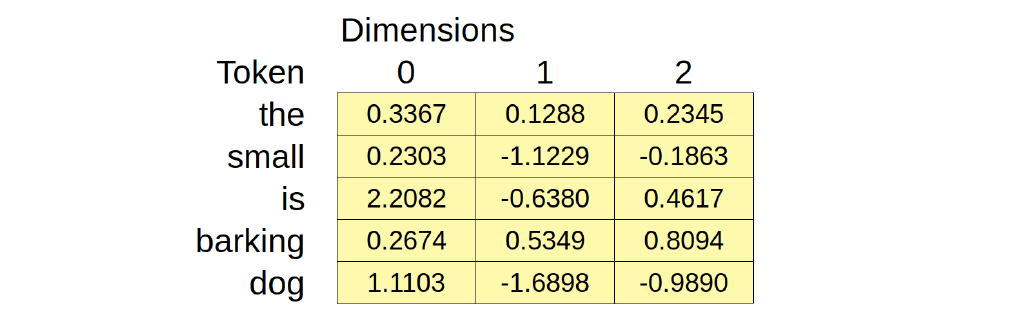

PyTorch’s `nn.Embedding` layer is a large lookup table.To actually
retrieve the values, we need to call the embedding layer with a list of token
indices, and it will return the corresponding rows of the table.

Let's retrieve the embeddings for the tokens "is" and "barking" using
their corresponding indices (two and three):

In [6]:
# tokens: ['is', 'barking']
dummy_cbow.embedding(torch.as_tensor([2, 3]))

tensor([[ 2.2082, -0.6380,  0.4617],
        [ 0.2674,  0.5349,  0.8094]], grad_fn=<EmbeddingBackward0>)

That’s why the main job of the tokenizer is to transform a
sentence into a list of token IDs. That list is used as an input to
the embedding layer, and from then on, the tokens are
represented by dense vectors.

In our former example, "dog" was the central word and the other four words were the context words:

In [7]:
tiny_vocab = ["the", "small", "is", "barking", "dog"]
context_words = ["the", "small", "is", "barking"]
target_words = ["dog"]

Now, let’s pretend that we tokenized the words and got their corresponding
indices:

In [8]:
batch_context = torch.as_tensor([[0, 1, 2, 3]]).long()
batch_target = torch.as_tensor([[4]]).long()

In its very first training step, the model would compute the continuous bag-ofwords
for the inputs by averaging the corresponding embeddings.

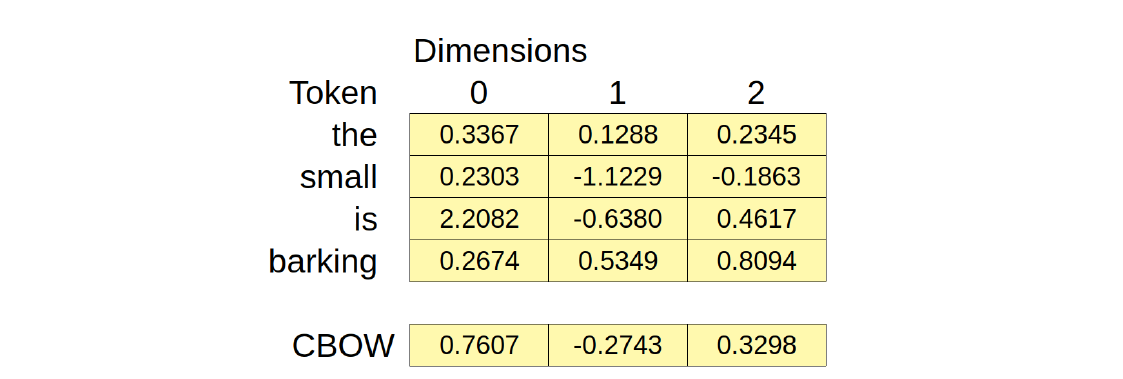

In [9]:
cbow_features = dummy_cbow.embedding(batch_context).mean(dim=1)
cbow_features

tensor([[ 0.7606, -0.2743,  0.3298]], grad_fn=<MeanBackward1>)

The bag-of-words has three dimensions, which are the features used to compute
the logits for our multiclass classification problem.

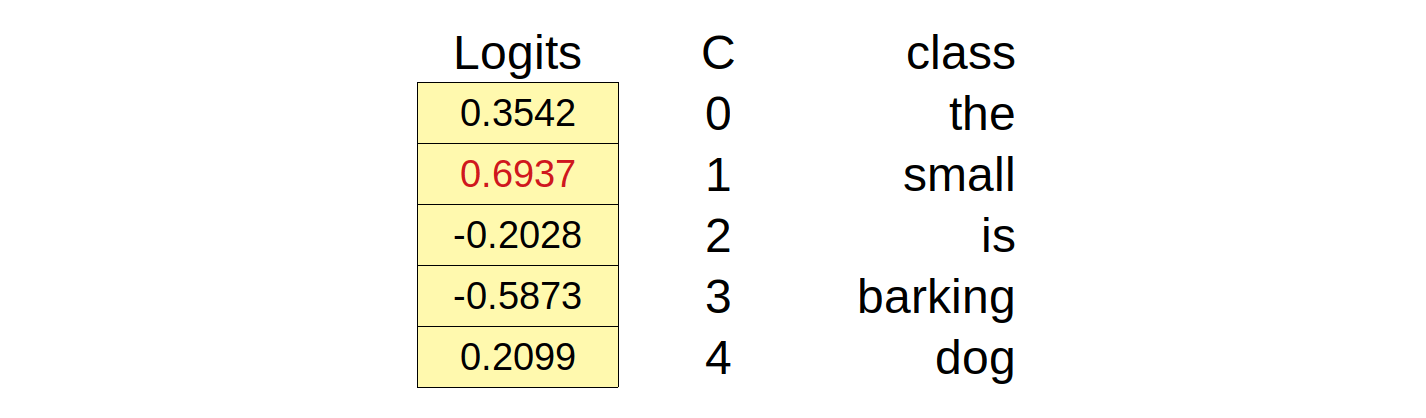

In [10]:
logits = dummy_cbow.linear(cbow_features)
logits

tensor([[ 0.3542,  0.6937, -0.2028, -0.5873,  0.2099]],
       grad_fn=<AddmmBackward0>)

The largest logit corresponds to the word "small" (class index one), so that would be
the predicted central word: "The small small is barking." The prediction is obviously
wrong, but, then again, that’s still a randomly initialized model.

Given a large enough dataset of context and target words, we could train the CBOW model above using an `nn.CrossEntropyLoss()` to learn actual word embeddings.